In [6]:
#!/usr/bin/env python
# coding:utf-8
 
#from xml.etree.ElementTree import Element, SubElement, tostring
from lxml.etree import Element, SubElement, tostring
import pprint
from xml.dom.minidom import parseString



def write_to_xml(path, folder, filename, obj_class, x1, y1, x2, y2, img_w, img_h, img_d):
    
    node_root = Element('annotation')
 
    node_folder = SubElement(node_root, 'folder')
    node_folder.text = folder
    node_filename = SubElement(node_root, 'filename')
    node_filename.text = filename+'.jpg'
    node_path = SubElement(node_root, 'path')
    node_path.text = path

    # Source from Japan UEC food 256 dataset
    node_source = SubElement(node_root, 'source')
    node_database = SubElement(node_source, 'database')
    node_database.text = 'UECfood256'

    node_size = SubElement(node_root, 'size')
    node_width = SubElement(node_size, 'width')
    node_width.text = img_w
    node_height = SubElement(node_size, 'height')
    node_height.text = img_h
    node_depth = SubElement(node_size, 'depth')
    node_depth.text = img_d

    node_segmented = SubElement(node_root, 'segmented')
    node_segmented.text = '0'

    
    node_object = SubElement(node_root, 'object')
    node_name = SubElement(node_object, 'name')
    node_name.text = obj_class
    
    node_pose = SubElement(node_object, 'pose')
    node_pose.text = 'Unspecified'
    node_truncated = SubElement(node_object, 'truncated')
    node_truncated.text = '0'
    node_difficult = SubElement(node_object, 'difficult')
    node_difficult.text = '0'


    node_bndbox = SubElement(node_object, 'bndbox')
    node_xmin = SubElement(node_bndbox, 'xmin')
    node_xmin.text = x1
    node_ymin = SubElement(node_bndbox, 'ymin')
    node_ymin.text = y1
    node_xmax = SubElement(node_bndbox, 'xmax')
    node_xmax.text = x2
    node_ymax = SubElement(node_bndbox, 'ymax')
    node_ymax.text = y2
 
    xml = tostring(node_root, pretty_print=False)  #格式化显示，该换行的换行
    dom = parseString(xml)


    filename =  "annotations/" + filename + ".xml"
    f = open(filename, "wb")
    f.write(dom.toprettyxml(indent='\t', encoding='utf-8'))
    f.close()

    #print(xml)
    
def find_category(current):
    category = open('category.txt', "rb")

    lines = category.readlines()

    for i in lines:
        i = i.strip()
        id=i.split('\t')[0]
        name = i.split('\t')[1]
        if(id==str(current)):
            return name;    

In [9]:
# write_to_xml(path, folder, filename, obj_class, x1, y1, x2, y2, img_w, img_h, img_d):

from PIL import Image


# Iterate 256 class, i.e., folder

for current in range(1,3):
    print(current)
    
    anno_path = 'images/' + str(current) + '/'

    bb = open( anno_path + 'bb_info.txt', "r")
    lines = bb.readlines()

    for line in lines:
        line = line.strip()
        name=line.split(' ')[0]
        x1=line.split(' ')[1]
        y1=line.split(' ')[2]
        x2=line.split(' ')[3]
        y2=line.split(' ')[4]

        # path of image
        path = '/home/wayne/workspace/food_data/' + name + '.jpg'
        # folder of class 
        folder = str(current)
        filename = name

        obj_class = find_category(current)

        #print(obj_class)

        if(name!="img"):
            img = Image.open(anno_path+name+'.jpg')
            img_w, img_h= img.size
            img_d = 3
            write_to_xml(path, folder, filename, str(obj_class), x1, y1, x2, y2, str(img_w), str(img_h), str(img_d) )
            #print(name,x1,y1,x2,y2)


1
2


## Turn xml to csv

In [205]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(), 'annotations')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('aka.csv', index=None)
    print('Successfully converted xml to csv.')

main()


Successfully converted xml to csv.


## Draw to see correctness

In [145]:
import cv2
import pandas as pd
from PIL import Image

In [183]:
full_labels = pd.read_csv('raccoon_labels.csv')

In [184]:
full_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,162.jpg,213,160,eels on rice,0,8,213,148
1,14806.jpg,240,320,rice,60,189,240,320
2,88.jpg,800,600,rice,49,307,340,560
3,176.jpg,210,158,eels on rice,0,0,201,148
4,14812.jpg,640,480,rice,56,240,290,480


In [186]:
def draw_boxes(image_name):
    selected_value = full_labels[full_labels.filename == image_name]
    img = cv2.imread('images/18/{}'.format(image_name))
    for index, row in selected_value.iterrows():
        img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 3)
        print(row['xmin'])
    return img


#Image.fromarray(draw_boxes('14812.jpg'))


60


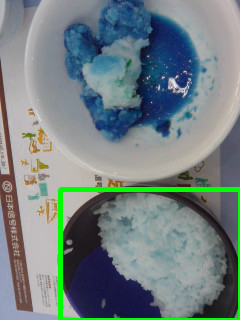

In [178]:
Image.fromarray(draw_boxes('14806.jpg'))

49


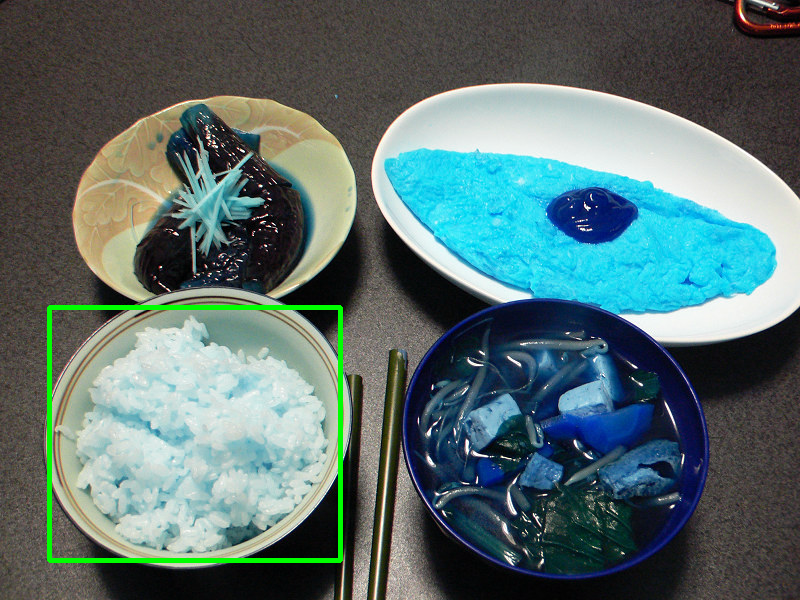

In [179]:
Image.fromarray(draw_boxes('88.jpg'))

0


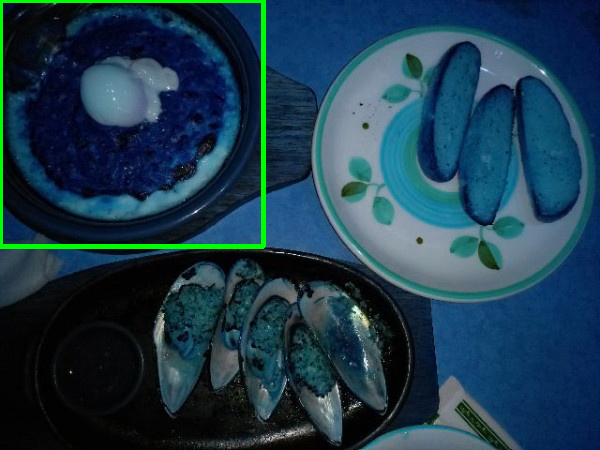

In [187]:
Image.fromarray(draw_boxes('15928.jpg'))

## Split into train / test data

In [189]:
import numpy as np
import pandas as pd
np.random.seed(1)

In [191]:
full_labels = pd.read_csv('raccoon_labels.csv')

In [192]:
full_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,162.jpg,213,160,eels on rice,0,8,213,148
1,14806.jpg,240,320,rice,60,189,240,320
2,88.jpg,800,600,rice,49,307,340,560
3,176.jpg,210,158,eels on rice,0,0,201,148
4,14812.jpg,640,480,rice,56,240,290,480


In [193]:
grouped = full_labels.groupby('filename')

In [194]:
grouped.apply(lambda x: len(x)).value_counts()

1    884
dtype: int64

In [195]:
gb = full_labels.groupby('filename')

In [196]:
grouped_list = [gb.get_group(x) for x in gb.groups]

In [197]:
len(grouped_list)

884

In [198]:
train_index = np.random.choice(len(grouped_list), size=160, replace=False)
test_index = np.setdiff1d(list(range(200)), train_index)

In [199]:
len(train_index), len(test_index)

(160, 162)

In [200]:
# take first 200 files
train = pd.concat([grouped_list[i] for i in train_index])
test = pd.concat([grouped_list[i] for i in test_index])

In [201]:
len(train), len(test)

(160, 162)

In [202]:
train.to_csv('train_labels.csv', index=None)
test.to_csv('test_labels.csv', index=None)

### Dealing with some stuff

In [219]:
category = open('category.txt', "r")

lines = category.readlines()
c = -1
for i in lines:
    c = c + 1
    i = i.strip()
    id = i.split('\t')[0]
    name = i.split('\t')[1]
   # print("elif row_label == '" + name + "':" )
   # print("    return "+str(c))
    print("item {")
    print("  id: "+str(id))
    print("  name: '"+name+"'")
    print("}")
    print()

item {
  id: id
  name: 'name'
}

item {
  id: 1
  name: 'rice'
}

item {
  id: 2
  name: 'eels on rice'
}

item {
  id: 3
  name: 'pilaf'
}

item {
  id: 4
  name: 'chicken-'n'-egg on rice'
}

item {
  id: 5
  name: 'pork cutlet on rice'
}

item {
  id: 6
  name: 'beef curry'
}

item {
  id: 7
  name: 'sushi'
}

item {
  id: 8
  name: 'chicken rice'
}

item {
  id: 9
  name: 'fried rice'
}

item {
  id: 10
  name: 'tempura bowl'
}

item {
  id: 11
  name: 'bibimbap'
}

item {
  id: 12
  name: 'toast'
}

item {
  id: 13
  name: 'croissant'
}

item {
  id: 14
  name: 'roll bread'
}

item {
  id: 15
  name: 'raisin bread'
}

item {
  id: 16
  name: 'chip butty'
}

item {
  id: 17
  name: 'hamburger'
}

item {
  id: 18
  name: 'pizza'
}

item {
  id: 19
  name: 'sandwiches'
}

item {
  id: 20
  name: 'udon noodle'
}

item {
  id: 21
  name: 'tempura udon'
}

item {
  id: 22
  name: 'soba noodle'
}

item {
  id: 23
  name: 'ramen noodle'
}

item {
  id: 24
  name: 'beef noodle'
}

item {
 

In [2]:
category = open('category.txt', "rb")

lines = category.readlines()

for i in lines:
    i = i.strip()
    id=i.split('\t')[0]
    name = i.split('\t')[1]
    print name

name
rice
eels on rice
pilaf
chicken-'n'-egg on rice
pork cutlet on rice
beef curry
sushi
chicken rice
fried rice
tempura bowl
bibimbap
toast
croissant
roll bread
raisin bread
chip butty
hamburger
pizza
sandwiches
udon noodle
tempura udon
soba noodle
ramen noodle
beef noodle
tensin noodle
fried noodle
spaghetti
Japanese-style pancake
takoyaki
gratin
sauteed vegetables
croquette
grilled eggplant
sauteed spinach
vegetable tempura
miso soup
potage
sausage
oden
omelet
ganmodoki
jiaozi
stew
teriyaki grilled fish
fried fish
grilled salmon
salmon meuniere
sashimi
grilled pacific saury
sukiyaki
sweet and sour pork
lightly roasted fish
steamed egg hotchpotch
tempura
fried chicken
sirloin cutlet
nanbanzuke
boiled fish
seasoned beef with potatoes
hambarg steak
steak
dried fish
ginger pork saute
spicy chili-flavored tofu
yakitori
cabbage roll
omelet
egg sunny-side up
natto
cold tofu
egg roll
chilled noodle
stir-fried beef and peppers
simmered pork
boiled chicken and vegetables
sashimi bowl
sushi b